### Experimenting with pymc and SVGD

I just installed pymc according to this website (https://www.pymc.io/projects/docs/en/latest/installation.html) in a new environment

In [1]:
# import
import pymc as pm
from pymc import model_to_graphviz
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

### Wisconsin Breast Cancer (Diagnostic) Dataset

We got this one suggested. The advantage is that it is directly available via sklearn. The disadvantage is maybe that with 30 there are a lot of features.

**Features:** 30 (real-valued inputs)

**Instances:** 569

**Problem:** Predict whether the cancer is benign or malignant based on cell nucleus characteristics.

**Benefits:** Offers a binary classification problem with more features than the Pima Indians dataset, allowing for a deeper exploration of feature relationships using logistic regression.

In [2]:
# Load the dataset
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target

# Display the first few rows of the DataFrame, only 3 as the output would be a bit long otherwise
print(df.head(3))

# Show the shape of the DataFrame to verify
print("Data shape:", df.shape)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   
2                 0.05999  ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Information on SVGD with can be found here: https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.SVGD.html

Before using the breast cancer data set, let's try it out with artificial data

### Trying PyMC out for the first time

In the following, the code just generates some artifical linear data and then defines a PyMC model with SVGD to fit the target distribution. In the end, the slope and intercept of 1000 samples is plotted

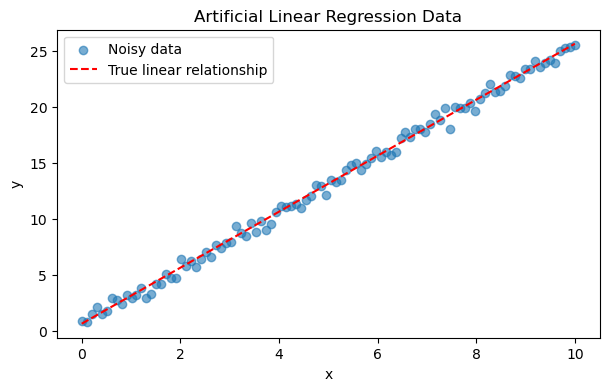

In [4]:
# Step 1: Generate Artificial Data
# We will create a simple linear regression dataset
np.random.seed(42)  # For reproducibility
x = np.linspace(0, 10, 100)  # 100 data points from 0 to 10
true_slope = 2.5
true_intercept = 0.65
# Generate noise
noise = np.random.normal(scale=0.5, size=len(x))
# Generate y values based on the linear model y = mx + c + noise
y = true_slope * x + true_intercept + noise

# Plotting the generated data
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.6, label='Noisy data')
plt.plot(x, true_slope * x + true_intercept, 'r--', label='True linear relationship')
plt.title('Artificial Linear Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [5]:
# Step 2: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as model:
    # Priors for the unknown model parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=slope * x + intercept, sigma=0.5, observed=y)

    # Step 3: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgd = pm.SVGD(n_particles=100, jitter=0.1, model=model)
    
    # Step 4: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approx = svgd.fit(10000)

Output()

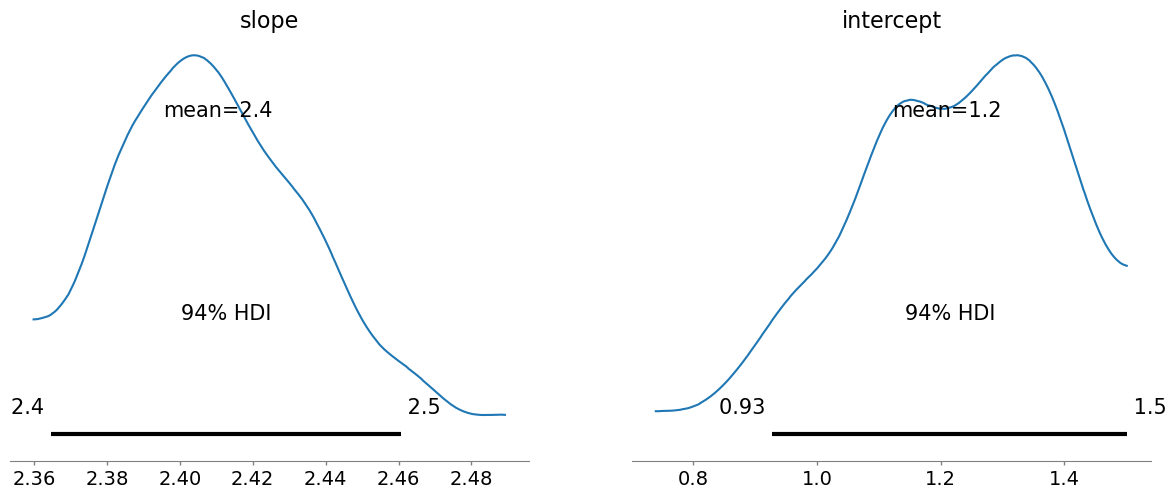

In [6]:
# Step 5: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
trace = approx.sample(100)

# Step 6: Visualize the Results
# plot the posterior distributions of the slope and the intercept
pm.plot_posterior(trace, var_names=['slope', 'intercept'])
plt.show()

In [7]:
az.summary(trace, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.21,0.16,0.93,1.50,0.02,0.01,71.27,58.41,NaN
slope,2.41,0.03,2.36,2.46,0.00,0.00,84.26,51.68,NaN


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

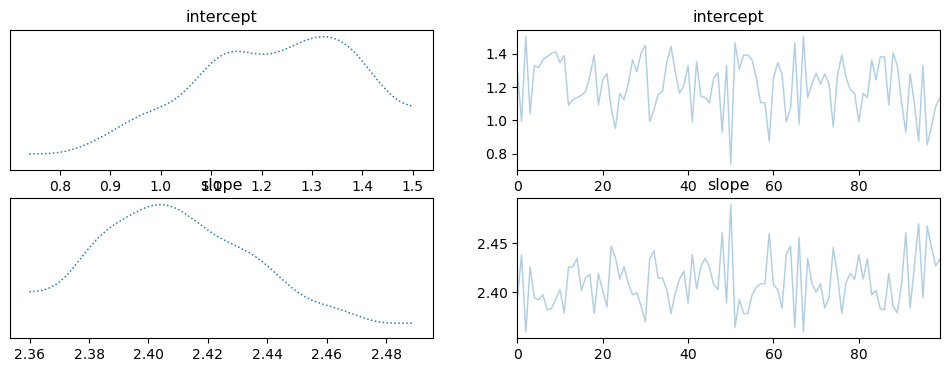

In [8]:
az.plot_trace(trace, combined=True)

### To Do:

- replace the artificial linear data by the breast cancer data set (and later maybe another one)
- using LMC on the same data for comparison
- try to implement SVGD ourselves for comparison
- compare the distributions / average

### The following cell is to adjust the model from above

In [9]:
# normalizing the features trying to solve a NaN problem
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_columns = df.columns[df.columns != 'target']
X = df[feature_columns].values
X_scaled = scaler.fit_transform(X)
df[feature_columns] = X_scaled
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0


In [10]:
X = df.drop('target', axis=1).values  # Features
y = df['target'].values  # Target variable

# Step 1: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as cancerModel:
    # Priors for the unknown model parameters
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    weights = pm.MvNormal('Weights', mu=0, cov = np.eye(30), shape=(X.shape[1],))

    # Calculate probabilities using the logistic function
    logits = intercept + pm.math.dot(X, weights)
    probability = pm.Deterministic('probability', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=probability, observed=y)

    # Step 2: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgdCancer = pm.SVGD(n_particles=100, jitter=0.1, model=cancerModel)
    
    # Step 3: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approxCancer = svgdCancer.fit(10000)

Output()

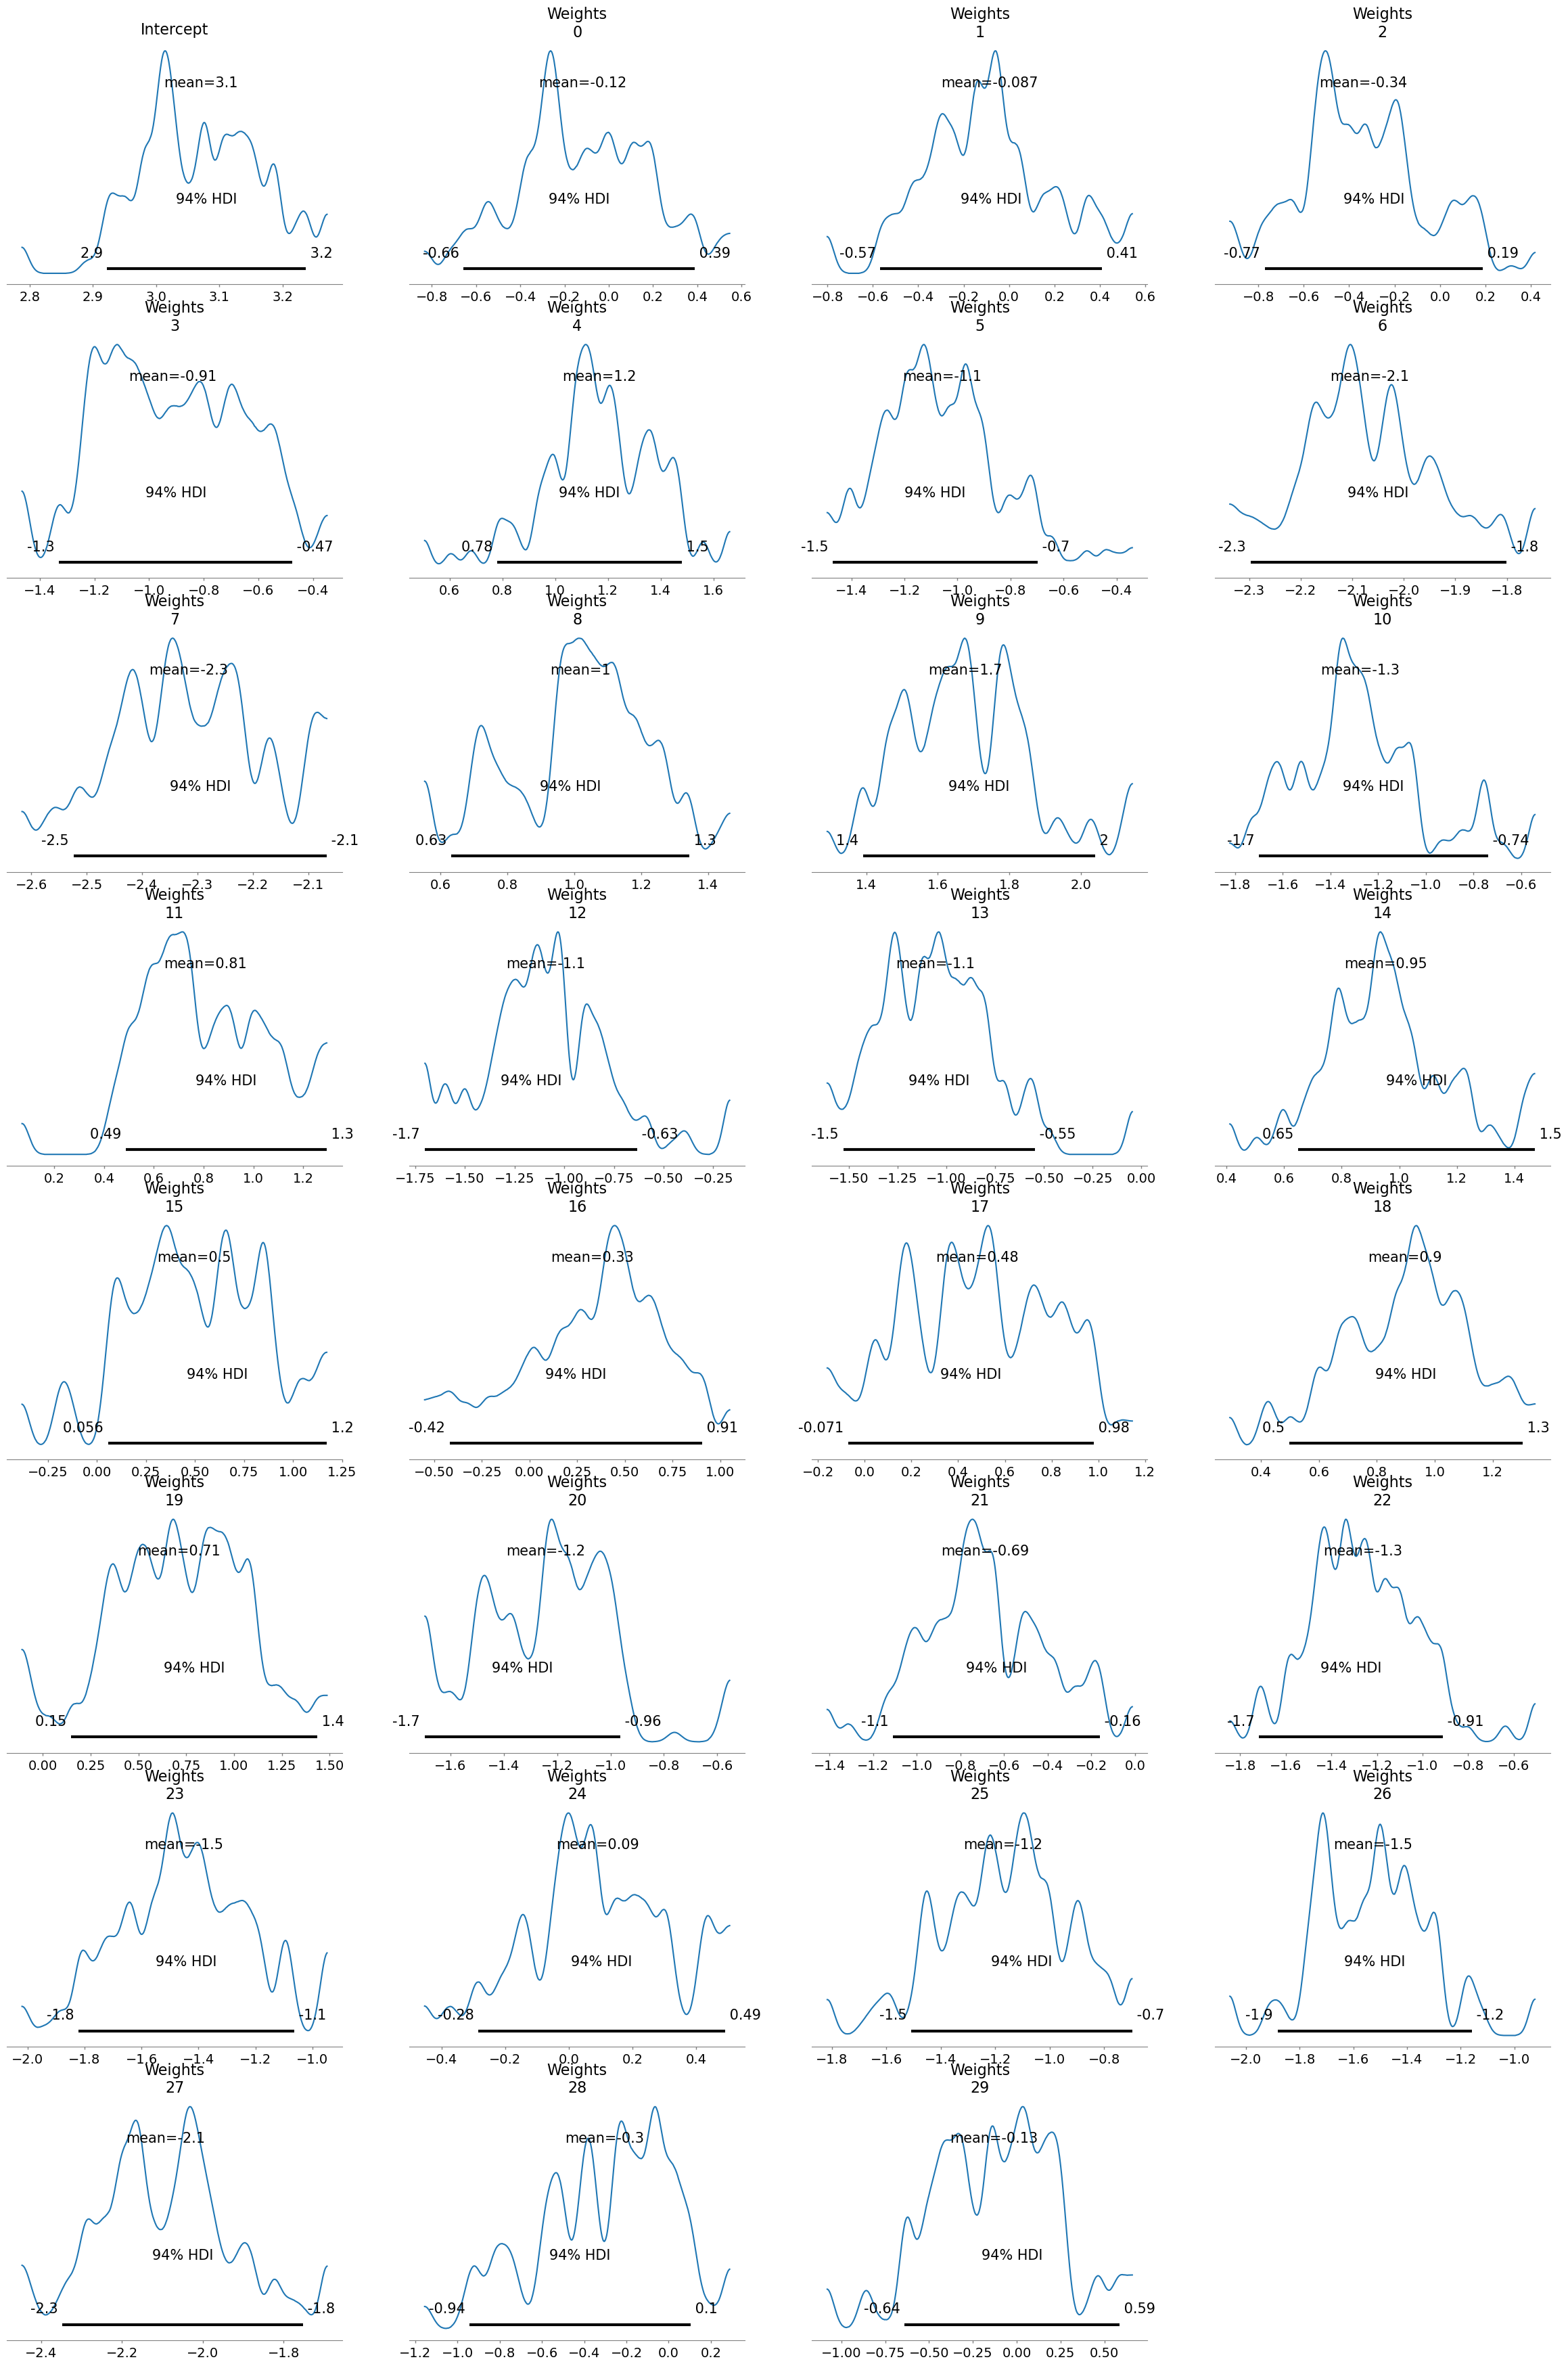

In [11]:
# Step 4: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
traceCancer = approxCancer.sample(1000)

# Step 5: Visualize the Results
pm.plot_posterior(traceCancer, var_names=['Intercept', 'Weights'])
plt.show()

## Analysis and Experiments

At this point in time, the model from above should work and we can run some experiments that help to understand the results better

In the following, I'm just adding some things for analysis, comparison etc. Let's think about what of this actually makes sense and what can be thrown out / what we need to add

In [12]:
pm.summary(traceCancer, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.07,0.09,2.92,3.24,0.00,0.00,932.45,824.36,NaN
Weights[0],-0.12,0.29,-0.66,0.39,0.01,0.01,564.38,901.09,NaN
Weights[1],-0.09,0.28,-0.57,0.41,0.01,0.01,826.60,847.35,NaN
Weights[2],-0.34,0.27,-0.77,0.19,0.01,0.01,1120.36,958.89,NaN
Weights[3],-0.91,0.25,-1.33,-0.47,0.01,0.01,1089.22,1044.95,NaN
...,...,...,...,...,...,...,...,...,...
probability[564],0.01,0.00,0.01,0.01,0.00,0.00,1191.05,980.41,NaN
probability[565],0.06,0.01,0.05,0.07,0.00,0.00,1121.30,987.67,NaN
probability[566],0.25,0.02,0.22,0.27,0.00,0.00,1012.89,966.91,NaN
probability[567],0.00,0.00,0.00,0.00,0.00,0.00,1044.77,896.53,NaN


https://www.pymc.io/projects/docs/en/latest/api/model/generated/pymc.model_graph.model_to_graphviz.html#pymc.model_graph.model_to_graphviz

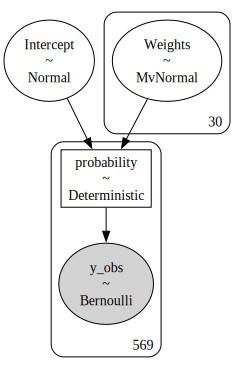

In [13]:
model_to_graphviz(cancerModel)

## Predictive Checks

Generate posterior predictive checks to see how well the model predicts new data. We're sampling from the posterior predictive distribution and compare these predictions to actual outcomes

Information can for example be found under the following link: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

### Step 1: Generate Posterior Predictive Data
After you've conducted your Bayesian inference and obtained the posterior distribution of the parameters, you can generate new data sets from these parameters. This is typically done using the model's likelihood function with parameter values drawn from the posterior distribution.

In [14]:
with cancerModel:
    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(traceCancer, var_names=['y_obs'])

Sampling: [y_obs]


Output()

In [15]:
print(posterior_predictive.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


### Step 2: Analyze the Generated Data

<Axes: xlabel='target', ylabel='Count'>

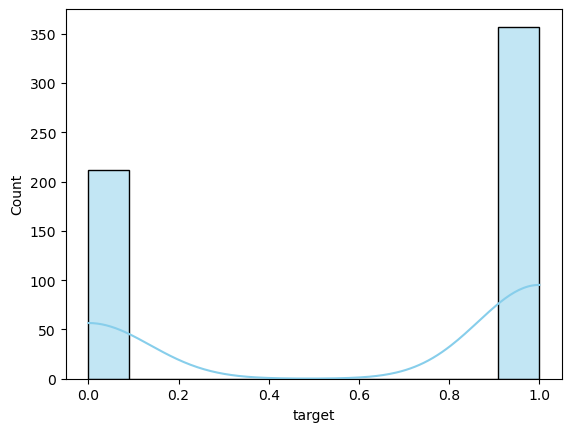

In [16]:
# Plot observed data
sns.histplot(data=df['target'], color="skyblue", label="Observed Data", kde=True)

<xarray.DataArray 'y_obs' (chain: 1, draw: 1000, y_obs_dim_2: 569)> Size: 5MB
array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 0, 1]]])
Coordinates:
  * chain        (chain) int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * y_obs_dim_2  (y_obs_dim_2) int64 5kB 0 1 2 3 4 5 ... 563 564 565 566 567 568


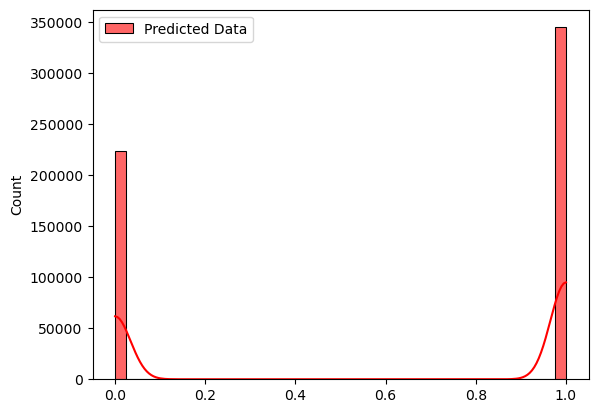

In [17]:
# Plot predicted data
posterior_predictive = posterior_predictive.posterior_predictive
predicted_data = posterior_predictive['y_obs']

# Check what's inside predicted_data
print(predicted_data)

# data had a 3D format with 1 markov chain, while sns.histplot() required 2D
flattened_data = predicted_data.values.flatten()

sns.histplot(flattened_data, color="red", label="Predicted Data", kde=True, alpha=0.6)

plt.legend()
plt.show()

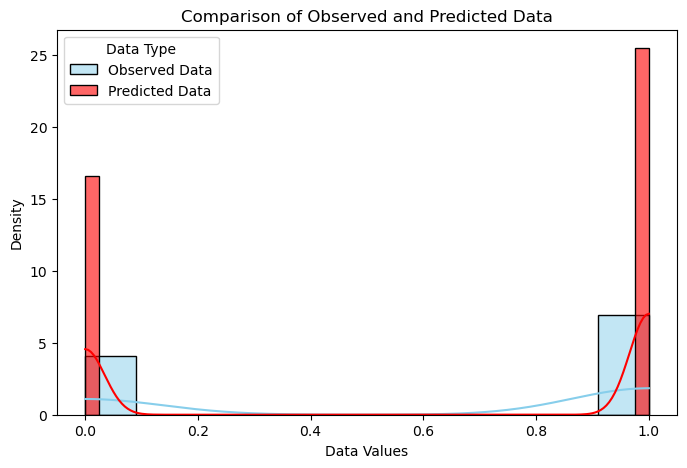

In [18]:
# Assuming df['target'] is your observed data
observed_data = df['target']

# Assume you already have your flattened_data from the posterior predictive
# Make sure to flatten your predicted data as you have done
flattened_data = predicted_data.values.flatten()

# Plot setup
plt.figure(figsize=(8, 5))

# Plotting observed data
sns.histplot(observed_data, color="skyblue", label="Observed Data", kde=True, stat="density")

# Plotting predicted data
sns.histplot(flattened_data, color="red", label="Predicted Data", kde=True, stat="density", alpha=0.6)

# Adding legend and titles
plt.legend(title="Data Type")
plt.title("Comparison of Observed and Predicted Data")
plt.xlabel("Data Values")
plt.ylabel("Density")
plt.show()

In [19]:
print("Observed Mean:", observed_data.mean())
print("Predicted Mean:", predicted_data.mean().item())

Observed Mean: 0.6274165202108963
Predicted Mean: 0.606115992970123
